### STEP 1: SETUP AND DEFINE PATHS

In [1]:

import os
import pandas as pd
import numpy as np
import cv2
import imghdr
import shutil
from pathlib import Path
import torch
import clip
from PIL import Image
from collections import defaultdict
import random

#Preprocessing
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


#visualization
import matplotlib.pyplot as plt



#models
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Path configuration
metadata_path = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\metadata.csv"
source_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species1"
dest_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species_filtered"

source_dir_clip = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species_filtered"
dest_dir_clip = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species_final"

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### STEP 2: EXPLORATORY DATA ANALYSIS

In [2]:
# Load metadata
metadata = pd.read_csv(metadata_path)
"""
This cell loads the metadata CSV file and analyzes the distribution of images across families.
It counts and calculates the percentage of images per family to assess dataset balance.
The output helps identify potential class imbalances that may need addressing.
"""
# Calculate image counts per family
family_stats = metadata['family'].value_counts().reset_index()
family_stats.columns = ['Family', 'Image Count']
family_stats['Percentage'] = (family_stats['Image Count'] / family_stats['Image Count'].sum()) * 100

# Display results
print("Dataset Balance by Family:")
print(family_stats.to_string(index=False))

Dataset Balance by Family:
           Family  Image Count  Percentage
  cercopithecidae          300    2.503547
      dactyloidae          300    2.503547
       formicidae          291    2.428440
   plethodontidae          270    2.253192
   carcharhinidae          270    2.253192
    salamandridae          270    2.253192
          bovidae          240    2.002837
      bucerotidae          210    1.752483
      acroporidae          210    1.752483
         anatidae          180    1.502128
      diomedeidae          180    1.502128
         atelidae          150    1.251773
          laridae          150    1.251773
           apidae          150    1.251773
        bufonidae          150    1.251773
       dasyatidae          150    1.251773
      delphinidae          120    1.001419
      agariciidae          120    1.001419
   callitrichidae          120    1.001419
      psittacidae          120    1.001419
     spheniscidae          120    1.001419
        iguanidae          

**Take-away**: Heavily imbalanced dataset, with half of the species with  only 30 ocorrencies

### STEP 3: DATASET QUALITY AND INTEGRITY

#### Size and format validation

In [3]:
# Image Filtering
"""
This cell processes images from rare_species1 folder (202 subfolders) and:
1. Filters images smaller than 40KB
2. Removes corrupted/invalid format images
3. Saves valid images to new rare_species_filtered directory
The output maintains the original folder structure with only quality images.
"""
valid_formats = ['jpeg', 'jpg', 'png', 'bmp']
min_size_kb = 10

# Counters
total_images = 0
valid_images = 0

# Create destination directory if not exists
os.makedirs(dest_dir, exist_ok=True)

for family_folder in os.listdir(source_dir):
    family_path = os.path.join(source_dir, family_folder)
    dest_family_path = os.path.join(dest_dir, family_folder)
    os.makedirs(dest_family_path, exist_ok=True)

    if not os.path.isdir(family_path):
        continue

    for image_file in os.listdir(family_path):
        total_images += 1
        src_path = os.path.join(family_path, image_file)
        dest_path = os.path.join(dest_family_path, image_file)

        try:
            # Check file size
            if os.path.getsize(src_path) < min_size_kb * 1024:
                continue

            # Check image format and corruption
            with Image.open(src_path) as img:
                img.verify()  # Verify integrity
                if img.format.lower() not in valid_formats:
                    continue

            # Copy valid image
            shutil.copy2(src_path, dest_path)
            valid_images += 1

        except:
            continue

# Summary
removed_images = total_images - valid_images
print(" Image filtering complete.")
print(f" Total images processed: {total_images}")
print(f" Valid images copied   : {valid_images}")
print(f" Images removed       : {removed_images}")
print(f" Output saved to       : {dest_dir}")

c:\Users\Elcano\anaconda3\envs\cv310\lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


 Image filtering complete.
 Total images processed: 11983
 Valid images copied   : 11929
 Images removed       : 54
 Output saved to       : C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species_filtered


### STEP 4: IMAGE SELECTION BASED ON CLIP MODEL


In [4]:
# CLIP-based Image Verification with Logging
"""
We apply CLIP model to:
1. Group similar images within each species folder
2. Keep only the largest coherent group per species
3. Save final verified images to rare_species_final
4. Log how many images were kept per species
"""

# Parameters
threshold = 0.7
summary = []

# Initialize CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Create destination directory
os.makedirs(dest_dir_clip, exist_ok=True)

def get_image_embeddings(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image)
        return image_features.cpu().numpy()
    except:
        return None

# Process each species
for species_folder in os.listdir(source_dir_clip):
    species_path = os.path.join(source_dir_clip, species_folder)
    dest_species_path = os.path.join(dest_dir_clip, species_folder)
    os.makedirs(dest_species_path, exist_ok=True)

    if not os.path.isdir(species_path):
        continue

    images = []
    embeddings = []

    for img_file in os.listdir(species_path):
        img_path = os.path.join(species_path, img_file)
        emb = get_image_embeddings(img_path)
        if emb is not None:
            images.append(img_path)
            embeddings.append(emb)

    if not images:
        continue

    total = len(images)

    embeddings = torch.tensor(np.vstack(embeddings))  # shape: [N, 512]
    similarities = torch.matmul(embeddings, embeddings.T)

    # Cluster based on threshold
    groups = []
    remaining = set(range(len(images)))

    while remaining:
        idx = remaining.pop()
        group = {idx}
        for other in list(remaining):
            if similarities[idx, other] > threshold:
                group.add(other)
                remaining.remove(other)
        groups.append(group)

    # Select largest group
    largest_group = max(groups, key=len)

    # Copy images
    for idx in largest_group:
        shutil.copy2(images[idx], dest_species_path)

    # Log result
    summary.append({
        "Species": species_folder,
        "Total Images": total,
        "Kept": len(largest_group),
        "Removed": total - len(largest_group),
        "Kept %": round(len(largest_group) / total * 100, 2)
    })

# Save summary log
df_summary = pd.DataFrame(summary)
summary_path = os.path.join(dest_dir_clip, "clip_filter_summary.csv")
df_summary.to_csv(summary_path, index=False)

# Final message
print(" CLIP filtering complete.")
print(f" Final images saved to: {dest_dir_clip}")
print(f" Summary saved to: {summary_path}")

 CLIP filtering complete.
 Final images saved to: C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species_final
 Summary saved to: C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\rare_species_final\clip_filter_summary.csv


In [5]:
# Dataset Sampling for Modeling
"""
This script samples 40% of images per species from the filtered dataset.
From this subset, it splits images into:
- 20% for training
- 10% for validation
- 10% for testing
Each subset is saved under its respective folder within dataset_sample, 
maintaining the original species folder structure.
Images are shuffled before sampling to ensure representative splits.
"""

# Paths
source_dir = dest_dir_clip  # directory with filtered species images
base_output_dir = os.path.join(Path(source_dir).parent, "dataset_sample")
train_dir = os.path.join(base_output_dir, "train")
val_dir = os.path.join(base_output_dir, "val")
test_dir = os.path.join(base_output_dir, "test")

# Create target directories
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Splitting ratios
total_sample_ratio = 0.4
train_ratio = 0.5   # 50% of 40% = 20%
val_ratio = 0.25    # 25% of 40% = 10%
test_ratio = 0.25   # 25% of 40% = 10%

# Process each species folder
for species_folder in os.listdir(source_dir):
    species_path = os.path.join(source_dir, species_folder)
    if not os.path.isdir(species_path):
        continue

    images = os.listdir(species_path)
    total_images = len(images)
    if total_images == 0:
        continue

    # Shuffle and sample 40% of images
    random.shuffle(images)
    sample_size = int(total_images * total_sample_ratio)
    sampled_images = images[:sample_size]

    # Split the 40% sample into train, val, test
    train_size = int(sample_size * train_ratio)
    val_size = int(sample_size * val_ratio)
    test_size = sample_size - train_size - val_size

    train_imgs = sampled_images[:train_size]
    val_imgs = sampled_images[train_size:train_size + val_size]
    test_imgs = sampled_images[train_size + val_size:]

    # Copy images to corresponding folders
    for split_imgs, split_dir in zip([train_imgs, val_imgs, test_imgs], [train_dir, val_dir, test_dir]):
        split_species_dir = os.path.join(split_dir, species_folder)
        os.makedirs(split_species_dir, exist_ok=True)
        for img_file in split_imgs:
            src_path = os.path.join(species_path, img_file)
            dest_path = os.path.join(split_species_dir, img_file)
            shutil.copy2(src_path, dest_path)

print("Sampling and dataset splitting complete.")
print("Training, validation, and test sets created under:", base_output_dir)

Sampling and dataset splitting complete.
Training, validation, and test sets created under: C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\dataset_sample


In [6]:
# Dataset Split Paths
base_path = Path(dest_dir_clip).parent / "dataset_sample"
splits = ["train", "val", "test"]

# Dictionary to hold counts
data_distribution = defaultdict(list)

# Count images per class per split
for split in splits:
    split_path = base_path / split
    for class_folder in os.listdir(split_path):
        class_path = split_path / class_folder
        if not class_path.is_dir():
            continue
        num_images = len([img for img in os.listdir(class_path) if os.path.isfile(class_path / img)])
        data_distribution["Split"].append(split)
        data_distribution["Species"].append(class_folder)
        data_distribution["Image Count"].append(num_images)

# Create DataFrame
df_distribution = pd.DataFrame(data_distribution)

# Pivot for summary view
df_pivot = df_distribution.pivot(index="Species", columns="Split", values="Image Count").fillna(0).astype(int)
df_pivot["Total"] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values("Total", ascending=False)

# Display results
print("Species distribution across splits:")
print(df_pivot.to_string())

# Optional: Save to CSV
summary_path = base_path / "class_distribution_summary.csv"
df_pivot.to_csv(summary_path)
print(f"\nClass distribution summary saved to: {summary_path}")

Species distribution across splits:
Split                         test  train  val  Total
Species                                              
chordata_cercopithecidae        30     60   30    120
chordata_dactyloidae            30     60   30    120
arthropoda_formicidae           29     58   29    116
chordata_salamandridae          28     53   26    107
chordata_plethodontidae         27     53   26    106
chordata_carcharhinidae         27     52   26    105
chordata_bovidae                24     48   24     96
cnidaria_acroporidae            21     42   21     84
chordata_bucerotidae            22     41   20     83
chordata_anatidae               18     36   18     72
chordata_diomedeidae            18     35   17     70
arthropoda_apidae               15     30   15     60
chordata_bufonidae              15     30   15     60
chordata_atelidae               15     30   15     60
chordata_laridae                16     29   14     59
chordata_dasyatidae             16     29   14

### STEP 5: PREPROCESSING

In [7]:
# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Define heavy augmentation for training (only)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define test/validation generator with only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Path definitions
train_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\dataset_sample\train"
val_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\dataset_sample\val"
test_dir = r"C:\Users\Elcano\Documents\NOVA IMS\2º Semester\Deep Learning\Project\dataset_sample\test"

# Load generators
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
present_classes = np.unique(train_generator.classes)

# Compute class weights for present classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=present_classes,
    y=train_generator.classes
)

# Map each present class to its computed weight
class_weights_dict = dict(zip(present_classes, class_weights))

Found 2359 images belonging to 202 classes.
Found 1161 images belonging to 202 classes.
Found 1232 images belonging to 202 classes.


### STEP 6: BUILDING THE MODEL

In [8]:
# Get number of classes from training generator
num_classes = train_generator.num_classes  # Ensures accurate class count

# Define model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

# Output layer for the correct number of classes
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model with ADAM optimizer
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### STEP 7: MODEL FIT

In [9]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks,  # early stopping, checkpoint, lr reduction
    verbose=1
)

# Save the final model
model.save('rare_species_model.h5')

Epoch 1/30
73/73 [==============================] - ETA: 0s - loss: 5.1760 - accuracy: 0.0206
Epoch 1: val_accuracy improved from -inf to 0.02604, saving model to best_model.h5
73/73 [==============================] - 115s 2s/step - loss: 5.1760 - accuracy: 0.0206 - val_loss: 5.0471 - val_accuracy: 0.0260 - lr: 1.0000e-04
Epoch 2/30
73/73 [==============================] - ETA: 0s - loss: 5.0505 - accuracy: 0.0370
Epoch 2: val_accuracy improved from 0.02604 to 0.04514, saving model to best_model.h5
73/73 [==============================] - 89s 1s/step - loss: 5.0505 - accuracy: 0.0370 - val_loss: 4.9837 - val_accuracy: 0.0451 - lr: 1.0000e-04
Epoch 3/30
73/73 [==============================] - ETA: 0s - loss: 4.9718 - accuracy: 0.0507
Epoch 3: val_accuracy improved from 0.04514 to 0.06424, saving model to best_model.h5
73/73 [==============================] - 89s 1s/step - loss: 4.9718 - accuracy: 0.0507 - val_loss: 4.9157 - val_accuracy: 0.0642 - lr: 1.0000e-04
Epoch 4/30
73/73 [======

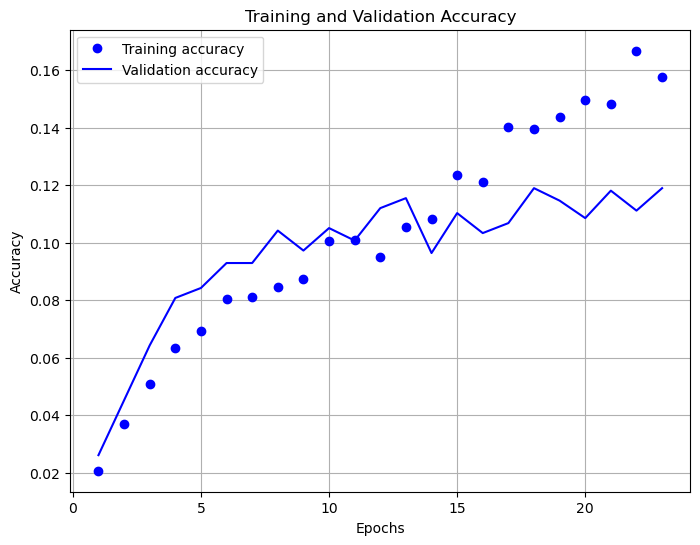

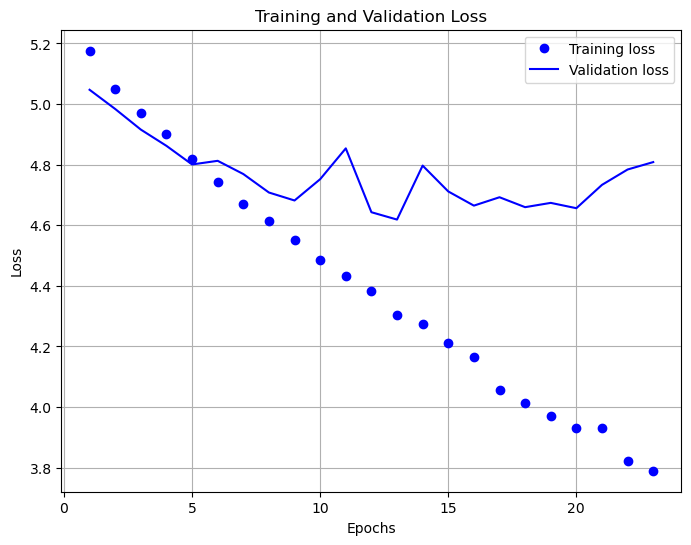

In [11]:
import matplotlib.pyplot as plt

# Correct keys based on 'metrics=['accuracy']' in model.compile
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

==============================================================================================================